In [2]:

import numpy as np
import scipy as sp
from astropy.io import fits as pyfits
from astropy.table import Table
import desispec.io
from desispec.interpolation import resample_flux
#from desitarget.targetmask import desi_mask
#import sys
import os
import scipy.optimize as scpo
import matplotlib.pyplot as plt

import fitsio

# Desi catalog test
import glob
from itertools import compress
import healpy

import empca



In [254]:
####  Catalog cutter eBoss
def cat_cutter_eBoss( Nnew ):
   file = '/work3/desi_lya/data/eBOSS/dr15_all/DR14Q_v4_4.fits' # Add here the filename, include the full path if necesary
   output = '/home/sfbeltranv/respaldo/DR14_mini/DR14Q_v4_4m.fits'
   output = '/home/sfbeltranv/respaldo/DR14_mini/picca150000.fits'

   hdul = pyfits.open(file)
   data = hdul[1].data
   hdul.info()

   # Nor: Origina size, Nnew: new size for the catalog (in overall items)
   Nor = len(data)
   print(Nor)
   #Nnew = 10000

   # Random Mask of Nnew items from the Nor items of the orignal catalog
   w = np.random.choice(Nor,Nnew,replace=False)

   if os.path.exists(output):
     os.remove(output)

   # Mask set in the catalog
   hdul[1].data = data[w]
   hdul.writeto(output)   # change name to the desired one.
   hdul.close()
   print('\n\nDone writing.\n')


   hdul = pyfits.open( output )
   data = hdul[1].data
   hdul.info()
   hdul.close() 
   print('\nDone with final size= ', len(data) )

cat_cutter_eBoss(150000)


Filename: /work3/desi_lya/data/eBOSS/dr15_all/DR14Q_v4_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (7055,)   uint8   
  1  DR14Q_v4_4    1 BinTableHDU    328   526356R x 105C   ['18A', 'D', 'D', 'J', 'I', 'J', 'I', '4A', 'D', 'D', '4A', 'D', 'D', 'D', 'I', 'D', 'D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'I', 'I', 'I', '51J', '51J', '51J', '51A', 'D', 'D', 'I', 'A', 'I', 'I', 'A', '5D', '5D', '5D', '5D', 'D', '5D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'I', 'D', 'D', 'E', 'I', 'D', 'D', 'E', 'I', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', '4A', '4A', 'D', 'E', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'I', 'D', 'D', 'D']   
526356


Done writing.

Filename: /home/sfbeltranv/respaldo/DR14_mini/picca150000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (7055,)   uint8  

In [69]:
####  Catalog cutter Desi
def cat_cutter_Desi( Nnew ):
   

   file = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/zcat.fits' # Add here the filename, include the full path if necesary
   output = '/home/sfbeltranv/respaldo/DR14_mini/zcat_m.fits'
   hdul = pyfits.open(file)
   data = hdul[1].data
   hdul.info()

   # Nor: Origina size, Nnew: new size for the catalog (in overall items)
   Nor = len(data)
   #Nnew = 10000

   # Random Mask of Nnew items from the Nor items of the orignal catalog
   w = np.random.choice(Nor,Nnew,replace=False)

   if os.path.exists(output):
     os.remove(output)

   # Mask set in the catalog
   hdul[1].data = data[w]
   hdul.writeto(output)   # change name to the desired one.
   hdul.close()
   print('\n\nDone writing.\n')


   hdul = pyfits.open( output )
   data = hdul[1].data
   hdul.info()
   hdul.close() 
   print('\nDone with final size= ', len(data) )
      
cat_cutter_Desi( 5000 )   

Filename: /work3/desi_lya/mocks_quick/london/v9.0.0_small/zcat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  ZCATALOG      1 BinTableHDU     39   142128R x 15C   ['D', '4D', 'D', 'D', 'K', '96A', '16A', 'K', 'D', '8A', 'D', 'D', 'E', 'E', 'E']   


Done writing.

Filename: /home/sfbeltranv/respaldo/DR14_mini/zcat_m.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  ZCATALOG      1 BinTableHDU     39   5000R x 15C   ['D', '4D', 'D', 'D', 'K', '96A', '16A', 'K', 'D', '8A', 'D', 'D', 'E', 'E', 'E']   

Done with final size=  5000


In [5]:
def normalizeSpec( x, y, xmin, xmax, normfactor = 6):
   
   xrange =  (x > xmin ) & (x < xmax ) 
   
   return y / ( np.sum(y[xrange]) * (x[1]-x[0]) ) * normfactor

def load_eBoss(path_drq, path_spec, zmin, zmax, lmin, lmax):
   # eBoss Catalog load
   catalog = Table.read(path_drq)
   
   w = (catalog['THING_ID']>0) & (catalog['Z'] > zmin ) & (catalog['Z']< zmax ) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
   reduced_cat = catalog[w]
   reduced_cat = reduced_cat.group_by('PLATE')

   thing_id = reduced_cat['THING_ID']
   fiberid = reduced_cat['FIBERID']
   plate = reduced_cat['PLATE']
   zqso = reduced_cat['Z']
   DEC = reduced_cat['DEC']
   RA = reduced_cat['RA']

   plate_list=[]
   for p,m in zip(reduced_cat['PLATE'],reduced_cat['MJD']):
        plate_list.append(str(p)+'/spPlate-'+str(p)+'-'+str(m)+'.fits')
   plate_list=np.unique(plate_list)

    #thisplate=plate_list[0].split("/")[1]  # Location
    #thisplate=plate_list[0].split("/")[0]  # Plate Number
   print('Found '+ str(  np.sum(w) ) + ' QSO spec. in ' +str(len(plate_list))+ ' files of catalog: '+ path_drq )
    
   spectra = []
   QSOloc = []
   ## begin for test
   for nplate in range ( 0, len(plate_list) ):      # len(plate_list)
      plate1=pyfits.open( path_spec+'/'+plate_list[nplate].split("/")[1] )
      thisplate=plate_list[nplate].split("/")[0]  # Plate Number

      wp = plate == int( thisplate )
      ids_=fiberid[wp]
      tids_=thing_id[wp]
      zqso_=zqso[wp]
      DEC_ = DEC[wp]
      RA_ = RA[wp]
      
      nqsoPlate_= ids_.shape[0]
      print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from plate: '+ plate_list[nplate].split("/")[1] )
      # Reading data from plate
      plugmap = plate1['PLUGMAP'].data
      # Searching for fiber of qso in data
      wp = np.in1d(plugmap['FIBERID'],ids_)
      # Applying mask to select only QSO
      small_plugmap = plugmap[wp]

      #Get the spectra
      flux=plate1[0].data
      #Get the weight
      ivar=plate1[1].data

      #Get the wavelenght
      pltheader=plate1[0].header
      coeff0=pltheader['COEFF0']
      coeff1=pltheader['COEFF1']
      logwave=coeff0+coeff1*np.arange(flux.shape[1])
      for i in range(0,nqsoPlate_):
            w_ = (10**logwave)/(1+zqso_[i])
            w_crop = ( w_ >= lmin ) & ( w_ <= lmax )
            w_ = w_[w_crop]
            flx = flux[ids_[i]-1][w_crop]
            ivr = ivar[ids_[i]-1][w_crop]
            flx = normalizeSpec( w_, flx, 1300, 1500)
            
            QSOloc.append( np.hstack(( zqso_[i], DEC_[i], RA_[i], tids_[i]  )) )
            s=np.vstack( ( w_.conj().transpose(), flx.conj().transpose(), ivr.conj().transpose() ) )
            spectra.append( s )
   print('Reading done.')   
   return QSOloc, spectra


#####################################
# Load QSO from plates     eBoss
### Parameters
path_spec      = '/work3/desi_lya/data/eBOSS/dr15_all/spplates'
path_drq       = '/home/sfbeltranv/respaldo/DR14_mini/picca5000.fits'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'

zmin = 2
zmax = 4

lmin = 1040
lmax = 1600

QSOloc_eBoss, spectra_eBoss = load_eBoss(path_drq, path_spec, zmin, zmax, lmin, lmax)



Found 1948 QSO spec. in 1358 files of catalog: /home/sfbeltranv/respaldo/DR14_mini/picca5000.fits
0: Loading 1 QSO spec. from plate: spPlate-3588-55184.fits
1: Loading 2 QSO spec. from plate: spPlate-3609-55201.fits
2: Loading 1 QSO spec. from plate: spPlate-3615-56544.fits
3: Loading 1 QSO spec. from plate: spPlate-3657-55244.fits
4: Loading 1 QSO spec. from plate: spPlate-3659-55181.fits
5: Loading 1 QSO spec. from plate: spPlate-3660-55209.fits
6: Loading 1 QSO spec. from plate: spPlate-3662-55182.fits
7: Loading 1 QSO spec. from plate: spPlate-3663-55176.fits
8: Loading 1 QSO spec. from plate: spPlate-3668-55478.fits
9: Loading 1 QSO spec. from plate: spPlate-3670-55480.fits
10: Loading 1 QSO spec. from plate: spPlate-3674-55182.fits
11: Loading 1 QSO spec. from plate: spPlate-3675-55183.fits
12: Loading 1 QSO spec. from plate: spPlate-3679-55209.fits
13: Loading 1 QSO spec. from plate: spPlate-3681-55243.fits
14: Loading 1 QSO spec. from plate: spPlate-3684-55246.fits
15: Loading 

135: Loading 1 QSO spec. from plate: spPlate-4211-55446.fits
136: Loading 1 QSO spec. from plate: spPlate-4213-55449.fits
137: Loading 1 QSO spec. from plate: spPlate-4219-55480.fits
138: Loading 1 QSO spec. from plate: spPlate-4220-55447.fits
139: Loading 1 QSO spec. from plate: spPlate-4221-55443.fits
140: Loading 1 QSO spec. from plate: spPlate-4222-55444.fits
141: Loading 1 QSO spec. from plate: spPlate-4223-55451.fits
142: Loading 1 QSO spec. from plate: spPlate-4226-55475.fits
143: Loading 3 QSO spec. from plate: spPlate-4227-55481.fits
144: Loading 2 QSO spec. from plate: spPlate-4228-55484.fits
145: Loading 1 QSO spec. from plate: spPlate-4231-55444.fits
146: Loading 1 QSO spec. from plate: spPlate-4232-55447.fits
147: Loading 3 QSO spec. from plate: spPlate-4233-55449.fits
148: Loading 2 QSO spec. from plate: spPlate-4234-55478.fits
149: Loading 1 QSO spec. from plate: spPlate-4238-55455.fits
150: Loading 1 QSO spec. from plate: spPlate-4239-55458.fits
151: Loading 1 QSO spec.

271: Loading 1 QSO spec. from plate: spPlate-4639-55944.fits
272: Loading 1 QSO spec. from plate: spPlate-4640-55927.fits
273: Loading 1 QSO spec. from plate: spPlate-4641-55947.fits
274: Loading 1 QSO spec. from plate: spPlate-4642-55926.fits
275: Loading 1 QSO spec. from plate: spPlate-4643-55946.fits
276: Loading 1 QSO spec. from plate: spPlate-4644-55922.fits
277: Loading 1 QSO spec. from plate: spPlate-4646-55622.fits
278: Loading 1 QSO spec. from plate: spPlate-4647-55621.fits
279: Loading 1 QSO spec. from plate: spPlate-4648-55673.fits
280: Loading 2 QSO spec. from plate: spPlate-4649-55621.fits
281: Loading 1 QSO spec. from plate: spPlate-4651-56008.fits
282: Loading 1 QSO spec. from plate: spPlate-4652-55672.fits
283: Loading 1 QSO spec. from plate: spPlate-4653-55622.fits
284: Loading 2 QSO spec. from plate: spPlate-4659-55587.fits
285: Loading 2 QSO spec. from plate: spPlate-4664-56192.fits
286: Loading 1 QSO spec. from plate: spPlate-4666-55832.fits
287: Loading 1 QSO spec.

408: Loading 2 QSO spec. from plate: spPlate-5023-55858.fits
409: Loading 1 QSO spec. from plate: spPlate-5024-55854.fits
410: Loading 1 QSO spec. from plate: spPlate-5025-55836.fits
411: Loading 1 QSO spec. from plate: spPlate-5026-55855.fits
412: Loading 1 QSO spec. from plate: spPlate-5032-56208.fits
413: Loading 1 QSO spec. from plate: spPlate-5033-56244.fits
414: Loading 2 QSO spec. from plate: spPlate-5034-56190.fits
415: Loading 1 QSO spec. from plate: spPlate-5036-55751.fits
416: Loading 1 QSO spec. from plate: spPlate-5039-56220.fits
417: Loading 2 QSO spec. from plate: spPlate-5042-55856.fits
418: Loading 2 QSO spec. from plate: spPlate-5043-56187.fits
419: Loading 1 QSO spec. from plate: spPlate-5044-56186.fits
420: Loading 1 QSO spec. from plate: spPlate-5047-55833.fits
421: Loading 1 QSO spec. from plate: spPlate-5049-56103.fits
422: Loading 1 QSO spec. from plate: spPlate-5051-56214.fits
423: Loading 2 QSO spec. from plate: spPlate-5055-55889.fits
424: Loading 1 QSO spec.

543: Loading 1 QSO spec. from plate: spPlate-5377-55957.fits
544: Loading 1 QSO spec. from plate: spPlate-5378-56011.fits
545: Loading 1 QSO spec. from plate: spPlate-5379-55986.fits
546: Loading 2 QSO spec. from plate: spPlate-5380-55980.fits
547: Loading 2 QSO spec. from plate: spPlate-5381-56009.fits
548: Loading 4 QSO spec. from plate: spPlate-5382-55982.fits
549: Loading 4 QSO spec. from plate: spPlate-5386-56008.fits
550: Loading 1 QSO spec. from plate: spPlate-5391-56000.fits
551: Loading 1 QSO spec. from plate: spPlate-5395-56003.fits
552: Loading 2 QSO spec. from plate: spPlate-5396-55947.fits
553: Loading 2 QSO spec. from plate: spPlate-5399-55956.fits
554: Loading 2 QSO spec. from plate: spPlate-5400-56308.fits
555: Loading 1 QSO spec. from plate: spPlate-5401-55949.fits
556: Loading 3 QSO spec. from plate: spPlate-5402-55927.fits
557: Loading 3 QSO spec. from plate: spPlate-5403-55979.fits
558: Loading 2 QSO spec. from plate: spPlate-5404-56013.fits
559: Loading 1 QSO spec.

680: Loading 1 QSO spec. from plate: spPlate-5861-56069.fits
681: Loading 2 QSO spec. from plate: spPlate-5862-56045.fits
682: Loading 1 QSO spec. from plate: spPlate-5863-56042.fits
683: Loading 1 QSO spec. from plate: spPlate-5864-56047.fits
684: Loading 1 QSO spec. from plate: spPlate-5865-56067.fits
685: Loading 2 QSO spec. from plate: spPlate-5866-56035.fits
686: Loading 2 QSO spec. from plate: spPlate-5868-56045.fits
687: Loading 1 QSO spec. from plate: spPlate-5870-56065.fits
688: Loading 1 QSO spec. from plate: spPlate-5873-56035.fits
689: Loading 1 QSO spec. from plate: spPlate-5878-56033.fits
690: Loading 1 QSO spec. from plate: spPlate-5880-56042.fits
691: Loading 1 QSO spec. from plate: spPlate-5881-56038.fits
692: Loading 1 QSO spec. from plate: spPlate-5884-56046.fits
693: Loading 1 QSO spec. from plate: spPlate-5885-56036.fits
694: Loading 1 QSO spec. from plate: spPlate-5886-56034.fits
695: Loading 3 QSO spec. from plate: spPlate-5890-56037.fits
696: Loading 1 QSO spec.

816: Loading 2 QSO spec. from plate: spPlate-6205-56187.fits
817: Loading 2 QSO spec. from plate: spPlate-6253-56574.fits
818: Loading 1 QSO spec. from plate: spPlate-6258-56238.fits
819: Loading 1 QSO spec. from plate: spPlate-6260-56568.fits
820: Loading 2 QSO spec. from plate: spPlate-6262-56267.fits
821: Loading 1 QSO spec. from plate: spPlate-6264-56223.fits
822: Loading 1 QSO spec. from plate: spPlate-6267-56279.fits
823: Loading 1 QSO spec. from plate: spPlate-6269-56246.fits
824: Loading 1 QSO spec. from plate: spPlate-6274-56550.fits
825: Loading 1 QSO spec. from plate: spPlate-6275-56245.fits
826: Loading 1 QSO spec. from plate: spPlate-6276-56269.fits
827: Loading 1 QSO spec. from plate: spPlate-6278-56266.fits
828: Loading 1 QSO spec. from plate: spPlate-6279-56243.fits
829: Loading 1 QSO spec. from plate: spPlate-6282-56572.fits
830: Loading 1 QSO spec. from plate: spPlate-6283-56239.fits
831: Loading 1 QSO spec. from plate: spPlate-6288-56192.fits
832: Loading 1 QSO spec.

952: Loading 1 QSO spec. from plate: spPlate-6630-56358.fits
953: Loading 1 QSO spec. from plate: spPlate-6631-56364.fits
954: Loading 1 QSO spec. from plate: spPlate-6633-56369.fits
955: Loading 1 QSO spec. from plate: spPlate-6634-56367.fits
956: Loading 1 QSO spec. from plate: spPlate-6635-56370.fits
957: Loading 1 QSO spec. from plate: spPlate-6636-56367.fits
958: Loading 3 QSO spec. from plate: spPlate-6637-56370.fits
959: Loading 1 QSO spec. from plate: spPlate-6638-56370.fits
960: Loading 1 QSO spec. from plate: spPlate-6639-56385.fits
961: Loading 1 QSO spec. from plate: spPlate-6643-56386.fits
962: Loading 2 QSO spec. from plate: spPlate-6646-56389.fits
963: Loading 2 QSO spec. from plate: spPlate-6649-56364.fits
964: Loading 2 QSO spec. from plate: spPlate-6659-56607.fits
965: Loading 1 QSO spec. from plate: spPlate-6660-56370.fits
966: Loading 1 QSO spec. from plate: spPlate-6661-56366.fits
967: Loading 1 QSO spec. from plate: spPlate-6664-56383.fits
968: Loading 1 QSO spec.

1085: Loading 1 QSO spec. from plate: spPlate-7097-56667.fits
1086: Loading 2 QSO spec. from plate: spPlate-7098-56661.fits
1087: Loading 2 QSO spec. from plate: spPlate-7103-56661.fits
1088: Loading 1 QSO spec. from plate: spPlate-7104-56711.fits
1089: Loading 4 QSO spec. from plate: spPlate-7106-56663.fits
1090: Loading 3 QSO spec. from plate: spPlate-7107-56740.fits
1091: Loading 1 QSO spec. from plate: spPlate-7108-56686.fits
1092: Loading 1 QSO spec. from plate: spPlate-7109-56658.fits
1093: Loading 3 QSO spec. from plate: spPlate-7111-56741.fits
1094: Loading 1 QSO spec. from plate: spPlate-7112-56666.fits
1095: Loading 1 QSO spec. from plate: spPlate-7114-56748.fits
1096: Loading 1 QSO spec. from plate: spPlate-7116-56681.fits
1097: Loading 2 QSO spec. from plate: spPlate-7117-56685.fits
1098: Loading 1 QSO spec. from plate: spPlate-7123-56726.fits
1099: Loading 1 QSO spec. from plate: spPlate-7127-56566.fits
1100: Loading 1 QSO spec. from plate: spPlate-7128-56567.fits
1101: Lo

1219: Loading 2 QSO spec. from plate: spPlate-7685-57062.fits
1220: Loading 1 QSO spec. from plate: spPlate-7687-57007.fits
1221: Loading 1 QSO spec. from plate: spPlate-7693-57361.fits
1222: Loading 1 QSO spec. from plate: spPlate-7694-57359.fits
1223: Loading 1 QSO spec. from plate: spPlate-7701-57356.fits
1224: Loading 1 QSO spec. from plate: spPlate-7703-57333.fits
1225: Loading 1 QSO spec. from plate: spPlate-7705-57332.fits
1226: Loading 2 QSO spec. from plate: spPlate-7714-57363.fits
1227: Loading 1 QSO spec. from plate: spPlate-7721-57360.fits
1228: Loading 2 QSO spec. from plate: spPlate-7818-56989.fits
1229: Loading 3 QSO spec. from plate: spPlate-7820-56984.fits
1230: Loading 1 QSO spec. from plate: spPlate-7824-57282.fits
1231: Loading 2 QSO spec. from plate: spPlate-7827-57278.fits
1232: Loading 2 QSO spec. from plate: spPlate-7833-57286.fits
1233: Loading 1 QSO spec. from plate: spPlate-7834-56979.fits
1234: Loading 1 QSO spec. from plate: spPlate-7836-57278.fits
1235: Lo

1353: Loading 1 QSO spec. from plate: spPlate-8866-57457.fits
1354: Loading 1 QSO spec. from plate: spPlate-8867-57460.fits
1355: Loading 2 QSO spec. from plate: spPlate-8871-57519.fits
1356: Loading 1 QSO spec. from plate: spPlate-8872-57422.fits
1357: Loading 1 QSO spec. from plate: spPlate-8873-57427.fits
Reading done.


In [5]:
def chi2( alpha, *args ):
   a,b = alpha
   w,flux,ivar = args
   return np.sum( (( flux - (a*w+b) )**2 ) * ivar )

In [6]:
#####################################
# Load QSO from plates     Desi
### Parameters
path_spec      = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16'
path_zcat      = '/work/sfbeltranv/DR14_mini/zcat_m.fits'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'

zmin = 2
zmax = 4

catalog = Table.read(path_zcat)


file = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16/10/1005/spectra-16-1005.fits' 
spec = Table.read( file )
#spec

h = pyfits.open( file )

h[0].header[4]

spectra_base= desispec.io.read_spectra( file )

spectra_base.__dict__
spectra_base.fibermap.__dict__
spectra_base.fibermap['TARGETID']

#spectra_base.meta
#spectra_base.meta['HPXPIXEL']

catalog['TARGETID']

80144322
10134274
30225742
70207669
70141515
20087445
50239965
63289
80205701
50143038
20053685


In [7]:
def splitID(fi_str):
   fi_str= fi_str.split("spectra-16-")[1]
   return fi_str.split(".fits")[0]


def load_Desi(path_zcat, path_spec, zmin, zmax, lmin, lmax):
   # Desi Catalog load, beginning of function
   catalog = Table.read(path_zcat)
   qso_string = catalog['SPECTYPE'][0]
   
   w = (catalog['SPECTYPE']==qso_string ) & (catalog['Z'] > zmin ) & (catalog['Z']< zmax ) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
   reduced_cat = catalog[w]

   nest = True
   in_nside = 16

   targetid = reduced_cat['TARGETID']
   zqso = reduced_cat['Z']
   DEC = reduced_cat['DEC'] * np.pi/180
   RA = reduced_cat['RA'] * np.pi/180

   heal_pix = healpy.ang2pix(in_nside, sp.pi/2.-DEC, RA, nest)
   plate_list = np.unique(heal_pix)
   fi = glob.glob(path_spec+'/*/*/spectra*.fits*')
   print('Found', len(fi), 'spectra files.\n')
   fi_fix = []
   for i in range( 0, len(fi)):
       fi_fix.append( splitID(fi[i]) )

   fi_fix =  np.array( list(map(int, fi_fix)) ) 
   
   print('Found '+ str(  np.sum(w) ) + ' QSO spec. in ' + str( len(plate_list) ) + ' files.' )
   
   spectra = []
   QSOloc = []
   
   ## begin for test
   for nplate in range( 0, len(plate_list) ):      # len(plate_list)
      thisplate = plate_list[ nplate ]
      wp = heal_pix == int( thisplate )
      
      ids_ = targetid[wp]
      zqso_= zqso[wp]
      DEC_ = DEC[wp]
      RA_ = RA[wp]
      heal_pix_ = heal_pix[wp]
      
      # heal_pix: From healpy.ang2pix
      # plate_list: Unique from healpy.ang2pix \n
      # fi_fix: Plate id from directory list
      # fi: All files from glob
      nqsoPlate_= ids_.shape[0]
      # print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from file: '+ [] )      
      wpf = fi_fix == thisplate
      index = wpf * np.arange( len(fi_fix) )
      index = np.squeeze( index[wpf] )
      
      
      #print( thisplate,  nqsoPlate_ , len(fi_fix) )
      
      # print( thisplate, fi_fix[index], nqsoPlate_, fi[index] )
      print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from file: '+  str(thisplate) )
      
      spectra_base = desispec.io.read_spectra( fi[index] )   
      
      joint1 = np.in1d( spectra_base.wave['b'], spectra_base.wave['r'])
      joint2 = np.in1d( spectra_base.wave['r'], spectra_base.wave['b'])
            
      ll = np.concatenate( ( spectra_base.wave['b'][np.invert(joint1)] , spectra_base.wave['r'] ) )
      
      for i in range(0,nqsoPlate_):
         
         index = np.where( np.array( spectra_base.fibermap['TARGETID'].data ) == ids_.data[i] )
         index = np.squeeze(index)
         
         w_ = (ll)/(1+zqso_[ i ])
         w_crop = ( w_ >= lmin ) & ( w_ <= lmax )
         w_ = w_[w_crop] 
         
         intersec = ( spectra_base.ivar['b'][ index ][joint1]*spectra_base.flux['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2]*spectra_base.flux['r'][ index ][joint2] )
         intersec = intersec /( spectra_base.ivar['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2] )

         flx = np.concatenate( ( spectra_base.flux['b'][ index ][np.invert(joint1)], intersec, \
               spectra_base.flux['r'][ index ][np.invert(joint2)] ) )
         flx = flx[w_crop]
         
         intersec = ( spectra_base.ivar['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2] ) 
         ivr = np.concatenate( ( spectra_base.ivar['b'][ index ][np.invert(joint1)], intersec, \
               spectra_base.ivar['r'][ index ][np.invert(joint2)] ) )
         ivr = ivr[w_crop]
         
         flx = normalizeSpec( w_, flx, 1300, 1500)
         #flx = normalizeSpec( w_, flx, 1300, 1500)

         
         QSOloc.append( np.hstack(( zqso_[i], DEC_[i], RA_[i], ids_[i] )) ) 
         s=np.vstack( ( w_.conj().transpose(), flx.conj().transpose(), ivr.conj().transpose() ) )
         spectra.append( s )
   
   print('Reading done.')
   return QSOloc, spectra


path_zcat = '/work/sfbeltranv/DR14_mini/zcat_m.fits' 
path_spec = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16'

zmin = 2.
zmax = 4.

lmin = 1040
lmax = 1600

QSOloc_Desi, spectra_Desi = load_Desi(path_zcat, path_spec, zmin, zmax, lmin, lmax)



Found 167 spectra files.

Found 4011 QSO spec. in 91 files.
0: Loading 61 QSO spec. from file: 0
1: Loading 20 QSO spec. from file: 1
2: Loading 48 QSO spec. from file: 2
3: Loading 16 QSO spec. from file: 3
4: Loading 60 QSO spec. from file: 8
5: Loading 26 QSO spec. from file: 9
6: Loading 45 QSO spec. from file: 10
7: Loading 46 QSO spec. from file: 11
8: Loading 32 QSO spec. from file: 14
9: Loading 57 QSO spec. from file: 32
10: Loading 65 QSO spec. from file: 33
11: Loading 52 QSO spec. from file: 34
12: Loading 36 QSO spec. from file: 35
13: Loading 58 QSO spec. from file: 36
14: Loading 31 QSO spec. from file: 37
15: Loading 55 QSO spec. from file: 38
16: Loading 50 QSO spec. from file: 39
17: Loading 45 QSO spec. from file: 40
18: Loading 50 QSO spec. from file: 41
19: Loading 45 QSO spec. from file: 42
20: Loading 35 QSO spec. from file: 43
21: Loading 64 QSO spec. from file: 44
22: Loading 59 QSO spec. from file: 45
23: Loading 61 QSO spec. from file: 46
24: Loading 48 QSO s

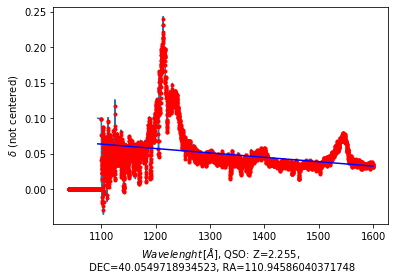

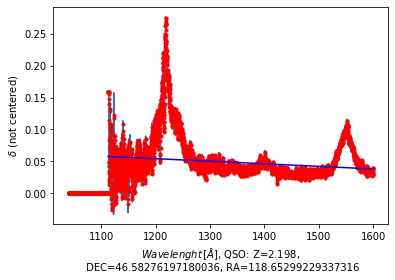

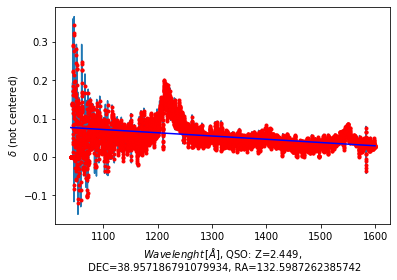

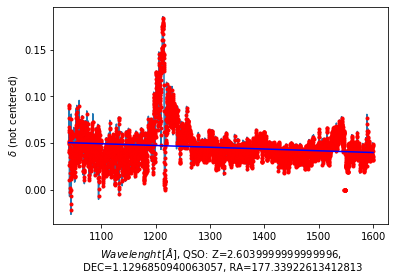

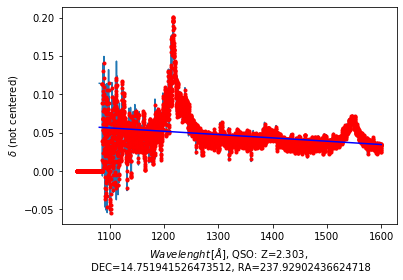

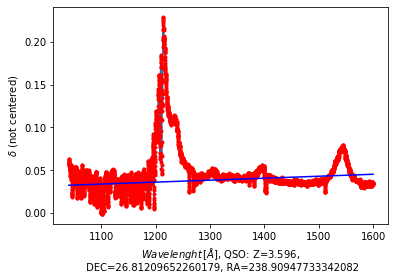

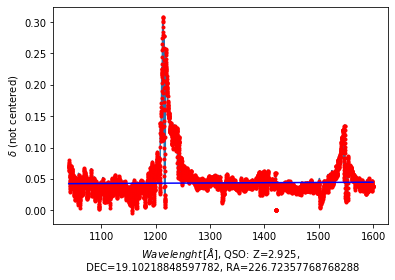

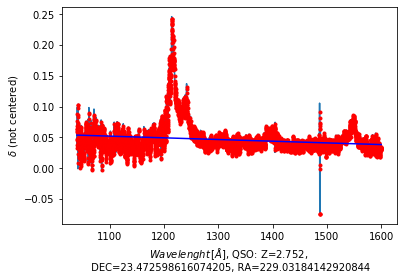

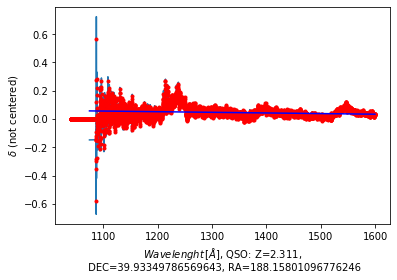

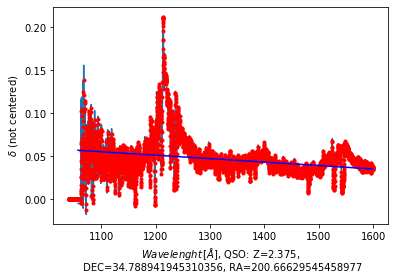

In [8]:
#### One QSO ploting example


spectra = spectra_eBoss
QSOloc = QSOloc_eBoss
wwave = sp.arange( lmin, lmax, .1) 


specSize = len(spectra)
specSize = 10

pcafluxm  = sp.zeros(( specSize, wwave.size))
pcaivarm  = sp.zeros(( specSize, wwave.size))

for nspectra in range( 0, specSize):
   # nspectra = 100
   s = spectra[ nspectra ]
   z, dec, ra, id_ = QSOloc[ nspectra ]
   w_ = s[0]
   flux_ = s[1]
   ivar_ = s[2]
   param = scpo.minimize(chi2, (1,1), args=( w_, flux_, ivar_) ); #COBYLA
   delta_ = flux_ / (param.x[0]*w_+param.x[1])  -  1
   
   pcafluxm[nspectra], pcaivarm[nspectra] = resample_flux( wwave, w_, flux_, ivar_ ) # interpolation

   plt.plot(w_,flux_)
   plt.plot(wwave, pcafluxm[nspectra], 'r.' )
   
   plt.plot(w_, param.x[0]*w_+param.x[1],'b'  )

   plt.xlabel( r'$Wavelenght\, [\AA]$, QSO: Z=' + str( z) + ',\n DEC=' + str( dec) +', RA=' + str( ra)  )
   plt.ylabel( r'$\delta$ (not centered)' )
   plt.show()


In [9]:
# def comovil distance calculation

z_ = np.linspace(0, 5., 1000)
r_ = np.zeros(1000)

omega_m = 0.31
omega_L = 0.69
cH0 = 3000

Hz = np.sqrt( omega_m * (1+z_)**3 + omega_L )

# defining the integral
dz = z_[1]-z_[0]

for i in range(1, z_.size):
    r_[i] = np.sum( cH0/Hz[:i] )*dz

def Rcomv(wave):
   z = (wave)/1216 - 1
   return np.interp(z, z_, r_)

# def conversion of r, declination and ra to x y z
def coordC(r,ra,dec):
   return r*np.cos(dec)*np.cos(ra), r*np.cos(dec)*np.sin(ra), r*np.sin(dec)


In [10]:
# OUTPUT function

#  z     = QSOloc_Desi[ i ][0]
#  dec   = QSOloc_Desi[ i ][1]
#  ra    = QSOloc_Desi[ i ][2]
#  id    = QSOloc_Desi[ i ][3]
#  w_    = spectra_Desi[ i ][ 0 ]
#  flux_ = spectra_Desi[ i ][ 1 ]
#  ivar_ = spectra_Desi[ i ][ 2 ]



def writeDelta(path_out, QSOloc, spectra, cat_type):
# save output
   out = fitsio.FITS(path_out+"/delta.fits.gz",'rw',clobber=True)
   print('Writting data from '+ str(len(QSOloc))+' QSOs')
   if ( cat_type == 'eBoss'):
      for i in range(0, len(QSOloc) ):
         hd = [ {'name':'RA','value':QSOloc[ i ][2],'comment':'Right Ascension [rad]'},
                 {'name':'DEC','value':QSOloc[ i ][1],'comment':'Declination [rad]'},
                 {'name':'Z','value':QSOloc[ i ][0],'comment':'Redshift'},
                 #{'name':'PMF','value':'{}-{}-{}'.format(d.plate,d.mjd,d.fid)},
                 {'name':'FIBER_ID','value':QSOloc[ i ][3],'comment':'Object identification'},
                 #{'name':'PLATE','value':d.plate},
                 #{'name':'MJD','value':d.mjd,'comment':'Modified Julian date'},
                 #{'name':'FIBERID','value':d.fid},
                 {'name':'ORDER','value':1,'comment':'Order of the continuum fit'},
         ]
         cols=[np.log10( spectra[i][0] ), spectra[i][1]*0, spectra[i][2], spectra[i][1]]
         names=['LOGLAM','DELTA','WEIGHT','CONT']
         units=['Log Angstrom','','','']
         comments = ['Log Lambda','Delta field','Pixel weights','Continuum']

         out.write(cols,names=names,header=hd,comment=comments,units=units,extname=str(QSOloc[ i ][3]))
   
   elif ( cat_type == 'Desi'):
      for i in range(0, len(QSOloc) ):
         hd = [ {'name':'RA','value':QSOloc[ i ][2],'comment':'Right Ascension [rad]'},
                 {'name':'DEC','value':QSOloc[ i ][1],'comment':'Declination [rad]'},
                 {'name':'Z','value':QSOloc[ i ][0],'comment':'Redshift'},
                 #{'name':'PMF','value':'{}-{}-{}'.format(d.plate,d.mjd,d.fid)},
                 {'name':'TARGET_ID','value':QSOloc[ i ][3],'comment':'Object identification'},
                 #{'name':'PLATE','value':d.plate},
                 #{'name':'MJD','value':d.mjd,'comment':'Modified Julian date'},
                 #{'name':'FIBERID','value':d.fid},
                 {'name':'ORDER','value':1,'comment':'Order of the continuum fit'},
         ]
         cols=[np.log10( spectra[i][0] ), spectra[i][1]*0, spectra[i][2], spectra[i][1]]
         names=['LOGLAM','DELTA','WEIGHT','CONT']
         units=['Log Angstrom','','','']
         comments = ['Log Lambda','Delta field','Pixel weights','Continuum']
         
         out.write(cols,names=names,header=hd,comment=comments,units=units,extname=str(QSOloc[ i ][3]))
   
   out.close()
   print('Done writting to file.')

path_out = '/home/sfbeltranv/respaldo/output/lya-deltas'
writeDelta(path_out, QSOloc_Desi, spectra_Desi, 'Desi')
writeDelta(path_out, QSOloc_eBoss, spectra_eBoss, 'eBoss')

Writting data from 4011 QSOs
Done writting to file.
Writting data from 112 QSOs
Done writting to file.


In [11]:
# Speed test for delta function selection
def f(a,b):
    return a+b
import timeit

deltaF = 'f'


start = timeit.default_timer()
#Your statements here
f(3, 4)
stop = timeit.default_timer()
print('Time: ', stop - start)  

n=3241241
start = timeit.default_timer()
#Your statements here
if n >= 0:
   f(3, 4)
elif(n>45):
   f(4,5)
else:
   f(1,1)
stop = timeit.default_timer()
print('Time: ', stop - start)  

start = timeit.default_timer()
#Your statements here
eval(deltaF)(3, 4)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  5.403999239206314e-05
Time:  7.543608080595732e-05
Time:  6.346008740365505e-05


In [12]:
def get_pca( spectra, niter, nvec):

   #### One QSO ploting example

   wwave = sp.arange( lmin, lmax, .1) 

   nbObj = len(spectra)
   # nbObj = 20

   pcaflux  = sp.zeros(( nbObj, wwave.size))
   pcaivar  = sp.zeros(( nbObj, wwave.size))

   for nspectra in range( 0, nbObj):
      pcaflux[nspectra], pcaivar[nspectra] = resample_flux( wwave, spectra[ nspectra ][0], spectra[ nspectra ][1], spectra[ nspectra ][2]) # interpolation

   pcaivar[pcaivar<0.] = 0.   # Remove if all measured bins are zero
   w = sp.sum(pcaivar,axis=0)>0.
   pcawave = wwave[w]
   pcaflux = pcaflux[:,w]
   pcaivar = pcaivar[:,w]
   ### Cap the ivar
   pcaivar[pcaivar>100.] = 100.

   ### Get the mean
   data_meanspec = sp.average(pcaflux,weights=pcaivar,axis=0) # Here, I get the mean spectrum.
   for i in range(nbObj):       #
      w = pcaivar[i]>0.        # subtracting the mean for each spectrum
      pcaflux[i,w] -= data_meanspec[w] #

   ### PCA
   print('INFO: Starting EMPCA')
   dmodel = empca.empca(pcaflux, weights=pcaivar, niter=niter, nvec=nvec)
        
   return dmodel, pcawave, pcaflux, pcaivar, data_meanspec


In [13]:
def get_continuum(wavelength,coeff,eigvec,mean_spec,n_vec=4,lmin=1300.0,lmax=1500.0,dw = 0.28):
   ### Choose the first four eigenvectors
   conti_mock = []
   for i in range(len(coeff)):
      spectram = []
      for j in range(n_vec):
         spectram.append(coeff[i][j]*eigvec[j])
      spectrasm = np.vstack(spectram)
      specm = np.sum(spectrasm,axis = 0)
      conti_mock += [specm]
   continuum_mock = np.vstack(conti_mock)
   ###
   new_wave = np.arange(600, 3000, dw)
   flux_mock = np.zeros((len(continuum_mock), new_wave.size))
   for i in range(len(continuum_mock)):
      flux_mock[i] = resample_flux(new_wave, wavelength, mean_spec+continuum_mock[i])
   ### Normalization
   integral_mock = []
   continuum_nor_mock = []
   for i in range(len(flux_mock)):
      sum2=0
      for j in range(len(flux_mock[i])):
         if lmin <= new_wave[j] < lmax :
            sum2+=(flux_mock[i][j])*(new_wave[j+1]-new_wave[j])
         elif (new_wave[j] > lmax):
            break
      integral_mock.append(sum2)
      continuum_nor_mock.append(8*flux_mock[i]/sum2)
   contin_mock = np.vstack(continuum_nor_mock)
   ### Normalization for the eigenvalues.
   coefficient = np.zeros((4,len(coeff)))
   for k in range(4):
      coefficient[k] = coeff[:,k]/integral_mock
   ### Stack
   stack_mock = np.mean(contin_mock,axis=0)     # mean continuum.
   std_stack_mock = np.std(contin_mock,axis=0)  # standard deviation.
   return new_wave, stack_mock, std_stack_mock, coefficient, contin_mock


#dmodel, pcawave, pcaflux, pcaivar, data_meanspec = get_pca(spectra_eBoss, 10, 10)
#dwave11, dmean11, dstd11, dcoeff11, dcontin_mock = get_continuum( pcawave, dmodel.coeff, dmodel.eigvec, data_meanspec)

#dmodel, pcawave, pcaflux, pcaivar, data_meanspec = get_pca(spectra_Desi, 10, 10)
#mwave11, mmean11, mstd11, mcoeff11, mcontin_mock = get_continuum( pcawave, dmodel.coeff, dmodel.eigvec, data_meanspec)




In [1]:
def plot_mean_cont(mwave,mflux,dwave,dflux,stdm,stdd,zmin,zmax,magmin,magmax,xmin,xmax,xminzoom,xmaxzoom):
   plt.figure(figsize=(14,15))
   plt.subplot(2,1,1)
   plt.title('Mean Continuum     {} < MAG < {} and {} < z < {}.'.format(magmin,magmax,zmin,zmax),fontsize = 20)
   plt.plot(dwave,dflux,'-', label='Stack DR14',alpha=0.7)
   #plt.fill_between(new_wave,stack_boss+std_stack_boss,stack_boss-std_stack_boss, label='std BOSS', color = 'y', alpha=0.5)
   plt.plot(mwave,mflux,'-', label='Stack MOCK',alpha=0.7)
   #plt.fill_between(new_wave,stack_mock+std_stack_mock,stack_mock-std_stack_mock, label='std MOCK', color = 'k', alpha=0.4)
   plt.xlim(xmin,xmax)
   #plt.ylim(-0.002,0.01)
   #axvline(940.93)
   plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
   plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
   plt.legend(fontsize='xx-large')
   plt.grid()

   mask = (dwave>900) & (dwave<1216)

   plt.subplot(2,1,2)
   plt.plot(dwave[mask],dflux[mask], label='Stack DR14')
   plt.fill_between(dwave[mask],dflux[mask]+stdd[mask],dflux[mask]-stdd[mask], label='std BOSS', color = 'y', alpha=0.5)
   plt.plot(mwave[mask],mflux[mask], label='Stack MOCK')
   plt.fill_between(mwave[mask],mflux[mask]+stdm[mask],mflux[mask]-stdm[mask], label='std MOCK', color = 'k', alpha=0.4)
   plt.xlim(xminzoom,xmaxzoom)
   #plt.ylim(0,0.04)
   plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
   plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
   plt.legend(fontsize='xx-large')
   plt.grid()

#plot_mean_cont(mwave11,mmean11,mwave11,mmean11,mstd11,mstd11,2.4,2.6,20.0,20.5,990,2200,990,1216)


NameError: name 'mwave11' is not defined

(1050, 1600)

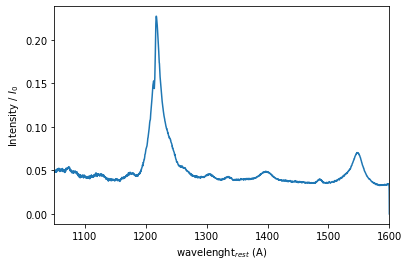

In [10]:
if 0:   #  Save / Load continuum with 10k obj catalog.
   np.save('wave',mwave11)
   np.save('meanf',mmean11)
   np.save('meanstd',mstd11)
else:
   mwave11 = np.load('wave.npy')
   mmean11 = np.load('meanf.npy')
   mstd11 = np.load('meanstd.npy')

plt.plot(mwave11, mmean11)
plt.xlabel(r'wavelenght$_{rest}$ (A)')
plt.ylabel(r'Intensity / $I_0$')
plt.xlim(1050,1600)

#plt.plot(mwave11, mstd11)                    




In [16]:
#nqso = 10


#plt.plot( pcawave, pcaflux[nqso] )
#plt.figure()
#plt.plot( dwave11, dcontin_mock[nqso] )
#plt.xlim((1040, 1500))  
#plt.figure()
#plt.plot( dwave11, dmean11 )

In [17]:
### PICCA loading example
if 0:
   dir  = '/home/sfbeltranv/respaldo/output/deltas_dr14/'


   catalog = pyfits.open(dir + 'delta-103.fits.gz')

   catalog[1].header

   #plt.plot( (10**catalog[1].data['LOGLAM'])/(1+catalog[1].header['Z']), catalog[1].data['DELTA'] )
   wlen = (10**catalog[1].data['LOGLAM'])/(1+catalog[1].header['Z'])

   print( wlen[0] )
   print(wlen[-1])



   catalog[1].header['THING_ID']
   catalog[1].header['Z']
   catalog[1].header


In [ ]:
## PCA Calculation Example

# OUTPUT function
#  z     = QSOloc[ i ][0]
#  dec   = QSOloc[ i ][1]
#  ra    = QSOloc[ i ][2]
#  id    = QSOloc[ i ][3]
#  w_    = spectra[ i ][ 0 ]
#  flux_ = spectra[ i ][ 1 ]
#  ivar_ = spectra[ i ][ 2 ]

spectra = spectra_eBoss
QSOloc = QSOloc_eBoss

dmodel, pcawave, pcaflux, pcaivar, data_meanspec = get_pca(spectra, 10, 10)
mwave11, mmean11, mstd11, mcoeff11, mcontin_mock = get_continuum( pcawave, dmodel.coeff, dmodel.eigvec, data_meanspec)

In [22]:
### PCA delta calculation and centering
def getdeltas_PCA( spectra, QSOloc, pcawave, pcacont, lamin=1040, lamax=1200):

   deltas = []

   for i in range( len(QSOloc) ):         # len(QSOloc)
      dwave = spectra[ i ][ 0 ]
      wmask = ( dwave >= lamin ) & ( dwave <= lamax )
      dwave = dwave[ wmask ]
      flux  = spectra[ i ][ 1 ]
      flux  = flux[ wmask]                        # orig flux
      ivr  =  spectra[ i ][ 2 ]
      ivr = ivr[ wmask]
      
      # pcawave, pcacont from cont. fitting with PCA to QSO delta ticks 
      # pcacont from pcawave to dwave
      cont  = resample_flux(dwave, pcawave, pcacont  )   # continuum fo dwave grid
      
      delta = flux / cont - 1
      delta = delta - np.sum(delta) / len(delta)     # zero Centered delta

      dwave = dwave * ( 1 + QSOloc[ i ][0] )   # restframe to selframe
      
      s=np.vstack( ( dwave.conj().transpose(), delta.conj().transpose(), ivr.conj().transpose() ) )
      deltas.append( s )
      #plt.figure()
      #plt.plot(dwave, flux, 'b') # orig flux
      #plt.plot(dwave, fluxm, 'r') # zero centered flux
      #plt.plot(dwave, flux*0+np.sum(flux) / len(flux) )  # mean of orig flux
      #plt.plot(dwave, fluxm*0, 'y')                      # zero line
      #plt.plot(dwave, delta)                              # continuum
      #plt.plot(dwave,delta)
   #plt.show()
   
   return deltas


deltas_eBoss_PCA = getdeltas_PCA(spectra_eBoss, QSOloc_eBoss, mwave11, mmean11 )
print('done')
print(len(deltas_eBoss_PCA))

done
112


In [23]:
def getdeltas_LinMinimize( spectra, QSOloc, lamin=1040, lamax=1200):

   deltas = []

   for i in range( len(QSOloc) ):         # len(QSOloc)
      
      w_, flux_, ivar_ = spectra[ i ]
      z, dec, ra, id_ = QSOloc[ i ]
      
      wmask = ( w_ >= lamin ) & ( w_ <= lamax )
      w_ = w_[wmask]
      flux_ = flux_[wmask]
      ivar_ = ivar_[wmask]
      
      param = scpo.minimize(chi2, (1,1), args=( w_, flux_, ivar_) ); #COBYLA
      CF = (param.x[0]*w_+param.x[1])
      
      delta_ = flux_ / CF  -  1
      delta_ = delta_ - np.sum(delta_) / len(delta_)     # zero Centered delta

      # dwave to observer frame and to comoving distance
      w_ = w_ * ( 1 + QSOloc[ i ][0] )   # restframe to selframe

      s=np.vstack( ( w_.conj().transpose(), delta_.conj().transpose(), ivar_.conj().transpose() ) )
      deltas.append( s )
      
      #plt.figure()
      #plt.plot( w_,flux_ )
      #plt.plot( w_, delta_ )
      #plt.plot( w_, CF, 'r' )
   #plt.show()
   
   return deltas


deltas_eBoss_linMin = getdeltas_LinMinimize(spectra_eBoss, QSOloc_eBoss )
print('done')
print(len(deltas_eBoss_linMin))

done
112


In [45]:
def load_Picca():

   ################# delta reading and loading with thing_id
   dir  = '/home/sfbeltranv/respaldo/output/deltas_dr14/'

   '''
   catalog = pyfits.open(dir + 'delta-100.fits.gz')

   catalog[1].header

   plt.plot( catalog[1].data['LOGLAM'], catalog[1].data['DELTA'] )

   catalog[1].header
   catalog[1].header['THING_ID']
   '''

   ################## script to load al healpix piles


   fi = glob.glob(dir+'*.fits*')

   spectra = []
   QSOloc = []

   for i in range( 0, len(fi) ):   # len( fi )
      catalog = pyfits.open( fi[i] ) 
      for j in range(1, len(catalog) ):
         QSOloc.append( np.hstack(( catalog[j].header['Z'], catalog[j].header['DEC'], catalog[j].header['RA'], int(catalog[j].header['THING_ID']) )) ) 
         # print(int(catalog[j].header['THING_ID']))
         s=np.vstack( ( 10**catalog[j].data['LOGLAM'], catalog[j].data['DELTA'], catalog[j].data['WEIGHT'] ) )
         spectra.append( s )
         
   return QSOloc, spectra


QSOloc_Picca, deltas_Picca = load_Picca()
print( len(deltas_Picca) )



99


3600.0 5513.184173484099
1.0
1915
3600.0
5514.0


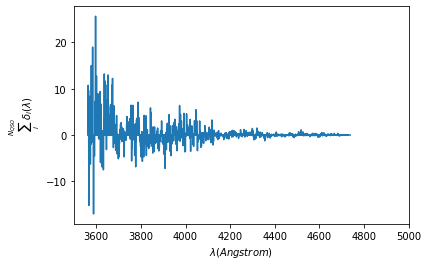

3549.7682446720896 5514.422023817434
1.0
1966
3550.0
5515.0


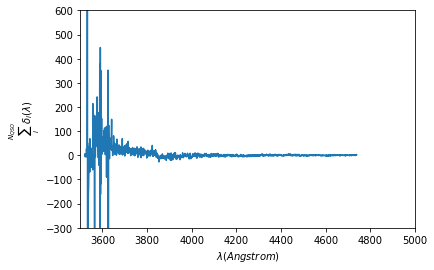

3549.7682446720896 5514.422023817434
1.0
1966
3550.0
5515.0


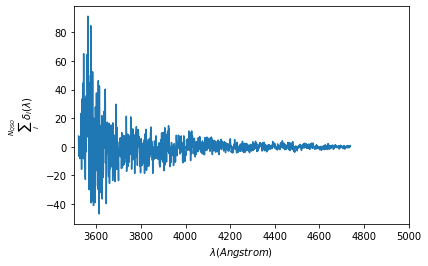

In [46]:
def getHist_deltas(deltas):

   min = 10000
   max = 0
   for i in range( len(deltas) ): 
      lmin = np.amin( deltas[i][0])
      lmax = np.amax( deltas[i][0])
      if( lmin  < min ):
         min = lmin
      if( lmax  > max ):
         max = lmax
   print( min, max )

   bin, step = np.linspace( np.ceil(min), np.ceil(max), num =  1*(1+  np.ceil(max)-np.ceil(min) ), retstep=True  )
   print(step)
   print(len(bin))
   print( bin[0] )
   print( bin[-1] )

   catalogLen = len(deltas)

   histZ = np.zeros_like((bin))
   len(histZ)

   for i in range( catalogLen ): 
      wave = deltas[i][0]
      delta = deltas[i][1]
      for j in range( len(wave) ): 
         ind = int( np.floor( (wave[j] -bin[0]+step) / step ) )
         histZ[ind] = histZ[ind] + delta[j]

   plt.plot(Rcomv( bin ),histZ)
   plt.xlim(3500,5000)
   #plt.ylim(-100,1000)
   plt.xlabel('$\lambda (Angstrom)$')
   plt.ylabel('$\sum_i^{ N_{QSO} }\delta_i (\lambda)$')

   plt.show()
   

getHist_deltas(deltas_Picca)
plt.ylim(-300,600)
getHist_deltas(deltas_eBoss_linMin)
#plt.ylim(-10,100)
getHist_deltas(deltas_eBoss_PCA)





3600.0 3828.269477158907
3600.0 3828.269477158907
$\delta_{PICCA}$ -2.4876510057338237    $\delta_{Instrument}$ -2.4876510057338237
4459.667711509329 5141.649888069057
4459.667711509329 5141.649888069057
$\delta_{PICCA}$ -3.081693574381461    $\delta_{Instrument}$ -3.081693574381461
3705.9751319733573 4272.70098472171
3705.9751319733573 4272.70098472171
$\delta_{PICCA}$ -2.5608813234102854    $\delta_{Instrument}$ -2.5608813234102854
3600.0 4048.5779062809365
3600.0 4048.5779062809365
$\delta_{PICCA}$ -2.4876510057338237    $\delta_{Instrument}$ -2.4876510057338237


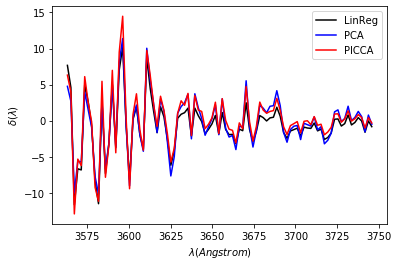

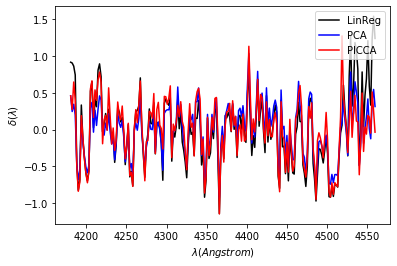

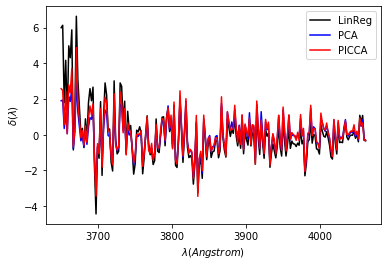

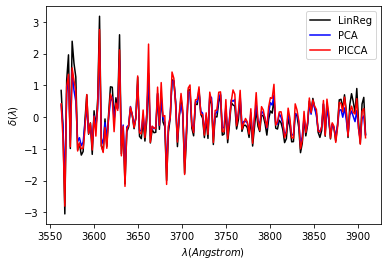

In [47]:

def compareDelta1(QSOloca, QSOlocb, spectraa1, spectraa2, spectrab):
# b for picca, a for Desi or eBoss
   a = np.array( QSOloca )
   b = np.array( QSOlocb )
   
   for i in  [4, 5, 6, 7] :         # range( len(b) ):
      indx = np.where( a[:,3] == b[i][3] )
      indx = np.squeeze(indx)
      ###  a -- indx, b --- i
      wa1_, fluxa1_, ivara1_ = spectraa1[ indx ]
      wa2_, fluxa2_, ivara2_ = spectraa2[ indx ]
      wb_, fluxb_, ivarb_ = spectrab[ i ]
      
      if 1:         # Resample flux to picca wave
      # fluxa from wa to wb
         fluxa1_  = resample_flux( wb_, wa1_, fluxa1_ )   # continuum fo dwave grid
         fluxa2_  = resample_flux( wb_, wa2_, fluxa2_ )   # continuum fo dwave grid
         wa1_ = wb_
         wa2_ = wb_
      print(wa1_[0], wa1_[-1])
      print(wb_[0], wb_[-1])

      
      plt.figure()
      plt.plot( Rcomv(wa2_), fluxa2_, 'black', label='LinReg' )
      plt.plot( Rcomv(wa1_), fluxa1_, 'b', label='PCA' )
      plt.plot( Rcomv(wb_), fluxb_, 'r', label='PICCA' )
      plt.legend( loc='upper right' )
      plt.xlabel('$\lambda (Angstrom)$')
      plt.ylabel('$\delta (\lambda)$')
      print( r"$\delta_{PICCA}$", wb_[0]-wb_[1], r"   $\delta_{Instrument}$", wa1_[0]-wa1_[1] )
      
      #print(a[indx,3])
      #print(b[i,3])
   plt.show()


compareDelta1( QSOloc_eBoss, QSOloc_Picca, deltas_eBoss_PCA, deltas_eBoss_linMin, deltas_Picca ) 






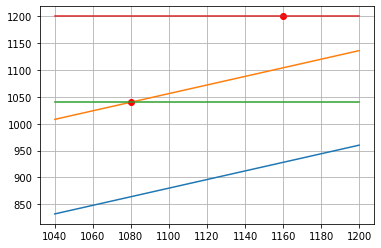

In [194]:
l = np.linspace(1040., 1200., 1000)
alpha = .8
l2 = alpha*l-alpha*1080+1040
l3 = alpha*l

plt.plot(l,l3)
plt.plot(l,l2)
plt.plot(1160,1200., 'ro')
plt.plot(1080,1040., 'ro')
plt.plot(l,l*0+1040)
plt.plot(l,l*0+1200)
plt.grid()


In [45]:
# QSOloc_eBoss, spectra_eBoss
# Healpix example

# OUTPUT function
#  z     = QSOloc[ i ][0]
#  dec   = QSOloc[ i ][1]
#  ra    = QSOloc[ i ][2]
#  id    = QSOloc[ i ][3]
#  w_    = spectra[ i ][ 0 ]
#  flux_ = spectra[ i ][ 1 ]
#  ivar_ = spectra[ i ][ 2 ]

a =  np.squeeze( np.array(QSOloc_eBoss ) )
a = np.array(QSOloc_eBoss)
#print( a[:][1] )
print( a.shape )

print(a[1:4, 3])
print(a[1:4, 2])
print(a[1:4])

(1948, 4)
[1.01363202e+08 1.15721691e+08 1.22686196e+08]
[30.63157718 31.15567151 36.79482965]
[[2.27700000e+00 3.77077470e-01 3.06315772e+01 1.01363202e+08]
 [2.78900000e+00 9.72554603e-01 3.11556715e+01 1.15721691e+08]
 [2.73700000e+00 1.08276588e+00 3.67948296e+01 1.22686196e+08]]


files:  69
/home/sfbeltranv/respaldo/output_blinded/deltas_dr14/delta-102.fits.gz


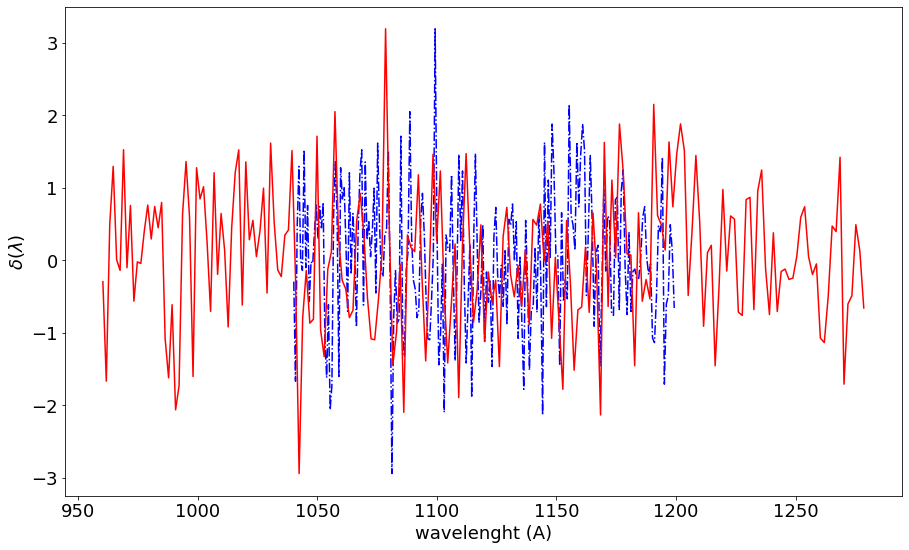

In [246]:
from matplotlib.lines import Line2D

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 9) # (w, h)
plt.rcParams.update({'font.size': 18})



import numpy as np
import scipy as sp
from astropy.io import fits as pyfits
from astropy.table import Table
import desispec.io
from desispec.interpolation import resample_flux
#from desitarget.targetmask import desi_mask
#import sys
import os
import scipy.optimize as scpo
import matplotlib.pyplot as plt

import fitsio

# Desi catalog test
import glob
from itertools import compress
import healpy

import empca




################# delta reading and loading with thing_id
dir  = '/home/sfbeltranv/respaldo/output_blinded/deltas_dr14/'

'''
catalog = pyfits.open(dir + 'delta-100.fits.gz')

catalog[1].header

plt.plot( catalog[1].data['LOGLAM'], catalog[1].data['DELTA'] )

catalog[1].header
catalog[1].header['THING_ID']
'''

################## script to load al healpix piles


fi = sorted(glob.glob(dir+'*.fits*'))

lmin = 1040
lmax = 1200

alpha = 2

print('files: ', len( fi ))

for i in range( 0, 1 ):   # len( fi )
   catalog = pyfits.open( fi[i] ,  mode='update')
   print(fi[i])
   #print('\t File ', i-int(sys.argv[1])+1, ' of ', 11, fi[i] )
   for j in range(1, 2 ):
      #print('\t QSO ', j, ' of ', len(catalog), '.' )
      
      w_1 = 10**( catalog[j].data['LOGLAM'] ) / (1 + catalog[j].header['Z'])
      w_2 = alpha*w_1 -alpha*1080+1040
      w_crop = ( w_2 >= lmin ) & ( w_2 <= lmax )
            
      plt.plot(w_1, catalog[j].data['DELTA'],'b-.')
      plt.plot(w_2, catalog[j].data['DELTA'],'r')

      #catalog[j].data['LOGLAM'] =  catalog[j].data['LOGLAM'] + np.log10(.85)
      
      plt.xlabel('wavelenght (A)')
      plt.ylabel(r'$\delta(\lambda)$')


   catalog.close()


      

In [195]:
#path=/work3/desi_lya/mocks_quick/london/v9.0.0_mini/spectra-16/11/1100

#truth-16-1100.fits

In [8]:
from matplotlib.lines import Line2D

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.rcParams.update({'font.size': 18})



import numpy as np
import scipy as sp
from astropy.io import fits as pyfits
from astropy.table import Table
import desispec.io
from desispec.interpolation import resample_flux
#from desitarget.targetmask import desi_mask
#import sys
import os
import scipy.optimize as scpo
import matplotlib.pyplot as plt

import fitsio

# Desi catalog test
import glob
from itertools import compress
import healpy

import empca




################# delta reading and loading with thing_id
dir  = '/home/sfbeltranv/respaldo/output/deltas/'

'''
catalog = pyfits.open(dir + 'delta-100.fits.gz')

catalog[1].header

plt.plot( catalog[1].data['LOGLAM'], catalog[1].data['DELTA'] )

catalog[1].header
catalog[1].header['THING_ID']
'''

################## script to load al healpix piles


fi = sorted(glob.glob(dir+'*.fits*'))

lmin = 1040
lmax = 1200

alpha = .8

print('files: ', len( fi ))

for i in range( 0, 1 ):   # len( fi )
   catalog = pyfits.open( fi[i] ,  mode='update')
   print(fi[i])
   #print('\t File ', i-int(sys.argv[1])+1, ' of ', 11, fi[i] )
   for j in range(1, 1 ):
      #print('\t QSO ', j, ' of ', len(catalog), '.' )
      
      w_1 = 10**( catalog[j].data['LOGLAM'] ) / (1 + catalog[j].header['Z'])
      w_2 = alpha*w_1-alpha*1040+1040
      w_crop = ( w_2 >= lmin ) & ( w_2 <= lmax )
      
      plt.figure()
      plt.plot(w_1,w_2,'r')
      plt.plot(w_1,w_1*alpha,'b')
      plt.plot(w_2[w_crop],w_2[w_crop]*0+1080,'ro')
      plt.plot(1160,1200., 'ro')
      plt.plot(1080,1040., 'ro')
      plt.plot(w_1,w_1*0+1040,'k')
      plt.plot(w_1,w_1*0+1200,'m')
      plt.grid()
      plt.ylim(900, 2500)
      #catalog[j].data['LOGLAM'] =  catalog[j].data['LOGLAM'] + np.log10(.85)
      
      plt.xlabel('R (h^{-1} Mpc)')

   catalog.close()

plt.show()
      

files:  47
/home/sfbeltranv/respaldo/output/deltas/delta-145.fits.gz


In [21]:
catalog[1].header


2.91502976417542